In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from utils import plot, read_ucm_params_kalibr, initRectifyMap, equirectangular_projection, \
  rotate_cw_90, rotate_ccw_90, rotate_180

In [2]:
from elas import *

In [3]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [15, 15]

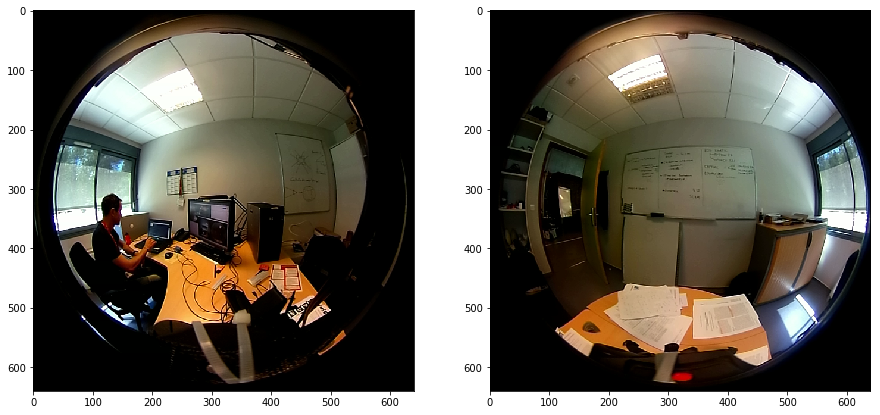

In [4]:
image_file = 'btm0000.png'
image = cv2.imread(image_file)
(rows,cols,channels) = image.shape
image_size = rows
btm_front_img = rotate_180(image[0:image_size, 0:image_size])
btm_back_img  = rotate_180(image[0:image_size, image_size:2*image_size])
plt.subplot(121); plot(btm_front_img);
plt.subplot(122); plot(btm_back_img);

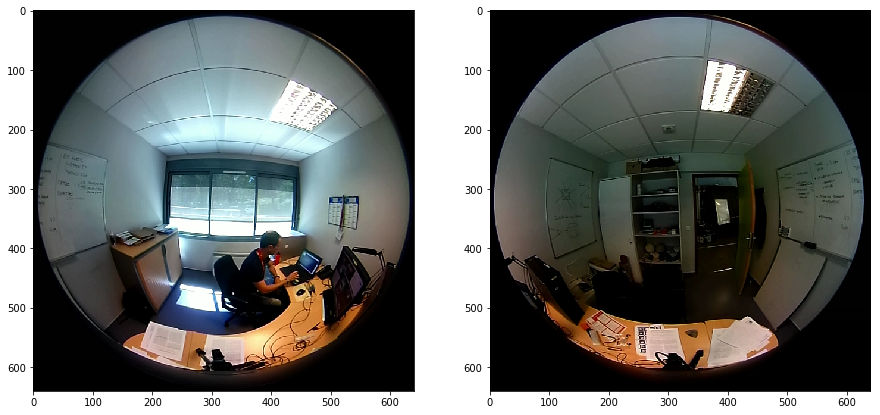

In [5]:
image_file = 'top0000.png'
image = cv2.imread(image_file)
(rows,cols,channels) = image.shape
image_size = rows
top_front_img = image[0:image_size, 0:image_size]
top_back_img  = image[0:image_size, image_size:2*image_size]
plt.subplot(121); plot(top_front_img);
plt.subplot(122); plot(top_back_img);

#### Use calibration parameters from Kalibr

In [6]:
params_file = '../../config/camchain-front_camera.yaml'
xi_f, K_f, D_f = read_ucm_params_kalibr(params_file)

In [7]:
params_file = '../../config/camchain-back_camera.yaml'
xi_b, K_b, D_b = read_ucm_params_kalibr(params_file)

### Compute rectification map and project into equirectangular image

In [8]:
map1_f, map2_f = initRectifyMap(K_f, D_f, xi_f)
map1_b, map2_b = initRectifyMap(K_b, D_b, xi_b)

In [9]:
btm_front_eqimg = equirectangular_projection(btm_front_img, map1_f, map2_f)
btm_back_eqimg = equirectangular_projection(btm_back_img, map1_b, map2_b)
btm_both_eqimg = np.concatenate((rotate_cw_90(btm_front_eqimg), rotate_cw_90(btm_back_eqimg)), axis=1)
btm_panorama = np.roll(btm_both_eqimg, 640, axis=1) # 320 + 320 (1/4 round)

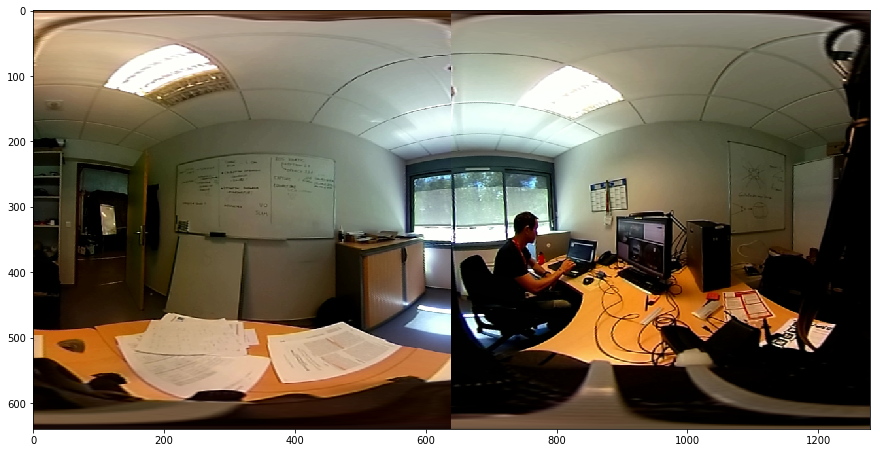

In [10]:
plot(btm_panorama);

In [11]:
top_front_eqimg = equirectangular_projection(top_front_img, map1_f, map2_f)
top_back_eqimg = equirectangular_projection(top_back_img, map1_b, map2_b)
top_both_eqimg = np.concatenate((rotate_cw_90(top_front_eqimg), rotate_cw_90(top_back_eqimg)), axis=1)
top_panorama = np.roll(top_both_eqimg, 350, axis=1) # typically 320, modified for horizontal alignment

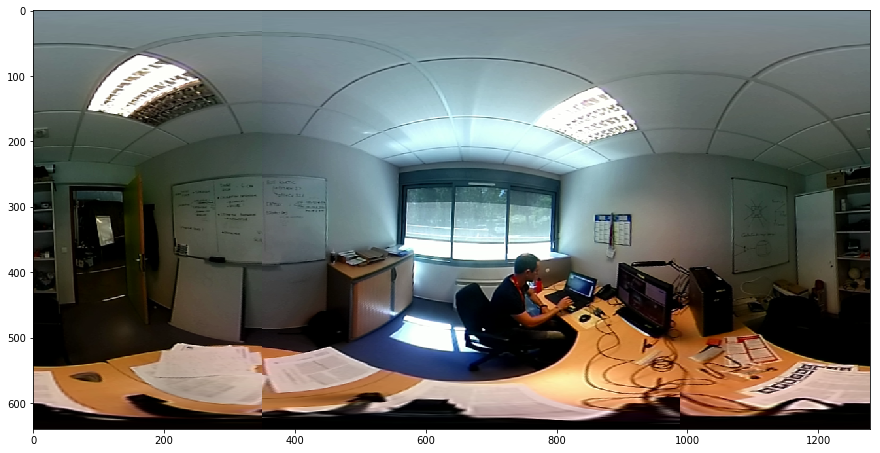

In [12]:
plot(top_panorama);

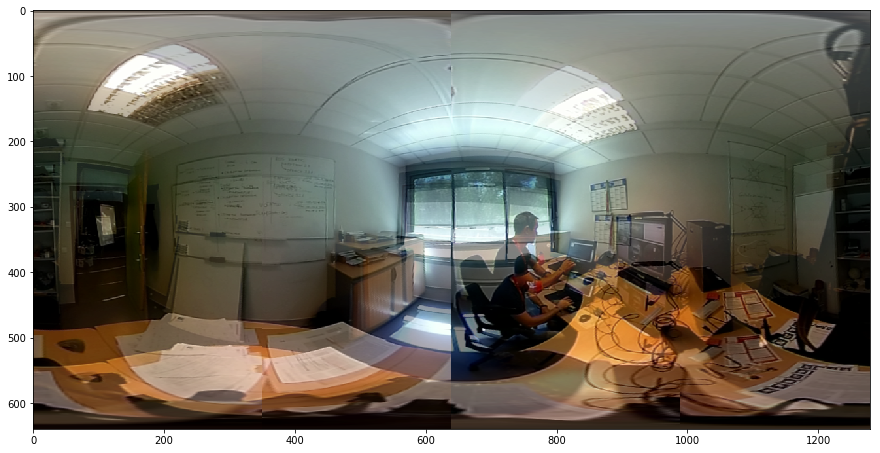

In [13]:
blended = cv2.addWeighted(btm_panorama,0.5,top_panorama,0.5,0)
plot(blended);

In [14]:
imgL = rotate_cw_90(top_panorama)
imgR = rotate_cw_90(btm_panorama)

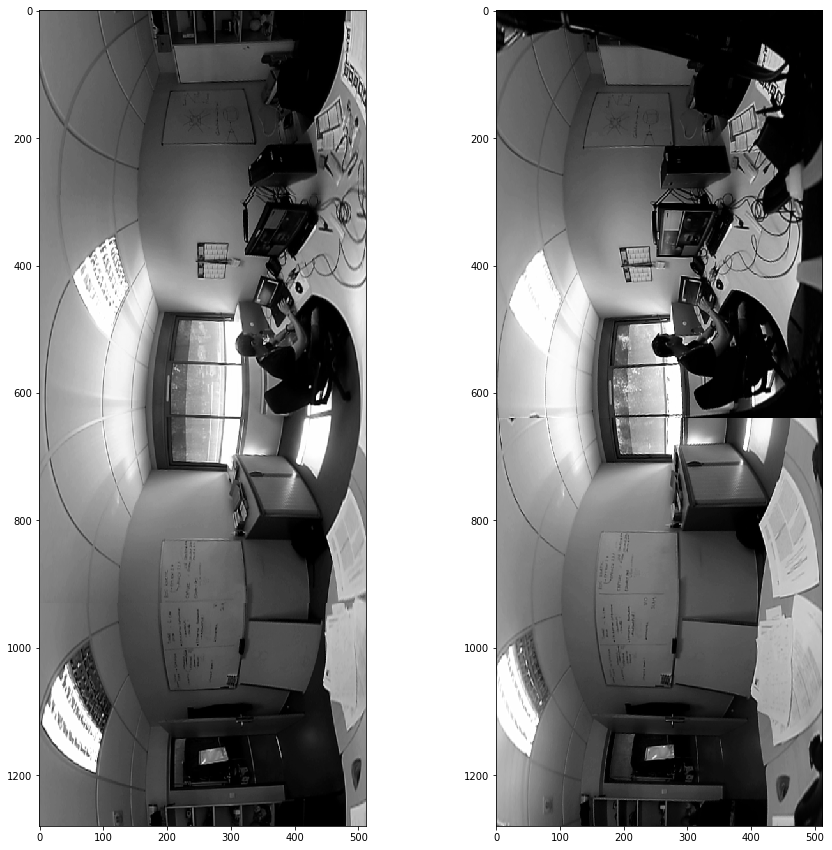

In [15]:
subimgL = cv2.cvtColor(imgL[:,64:576], cv2.COLOR_BGR2GRAY)
subimgR = cv2.cvtColor(imgR[:,64:576], cv2.COLOR_BGR2GRAY)
plt.subplot(121); plt.imshow(subimgL, cmap='gray');
plt.subplot(122); plt.imshow(subimgR, cmap='gray');

In [16]:
d1 = np.empty_like(subimgL, dtype=np.float32)
d2 = np.empty_like(subimgR, dtype=np.float32)

params = Elas_parameters()
params.postprocess_only_left = False
elas = Elas(params)

elas.process_stereo(subimgL, subimgR, d1, d2)

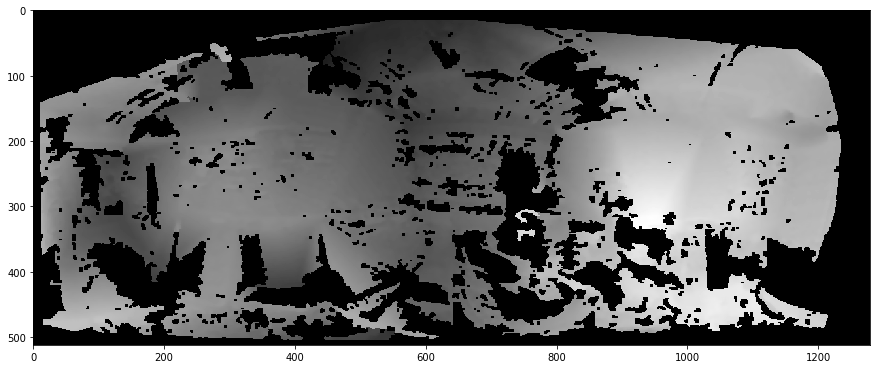

In [17]:
#scaled_d1 = (d1 / np.amax(d1) * 255.0).astype(np.uint8)
plt.imshow(rotate_ccw_90(d1), cmap='gray');

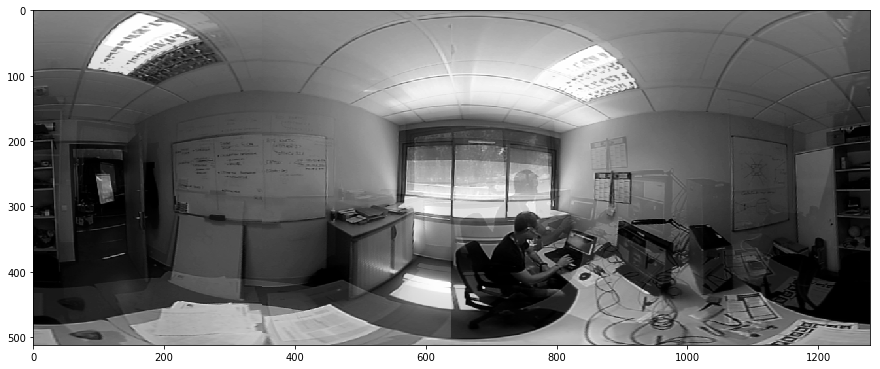

In [18]:
plt.imshow(rotate_ccw_90(cv2.addWeighted(subimgL,0.8,subimgR,0.2,0)), cmap='gray'); 